Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

**Load pickle file from google drive**
If you use Google colab to run this (which is faster as they have better GPU there), run this and upload your pickle file to google file and replace the id

In [0]:
!pip install PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# load the pickle and rename it to "notMNIST_dataset.pickle", replace this id with your pickle id
download = drive.CreateFile({'id': '1U3GGYjT5tlxjmqBTwNClU_DmiSaiubWD'})
download.GetContentFile('notMNIST_dataset.pickle')

**Prepare dataset**

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
%matplotlib inline

Load the downloaded pickle file

In [2]:
pickle_file = 'notMNIST_dataset.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (423260, 28, 28) (423260,)
Validation set (105820, 28, 28) (105820,)
Test set (18724, 28, 28) (18724,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (423260, 28, 28, 1) (423260, 10)
Validation set (105820, 28, 28, 1) (105820, 10)
Test set (18724, 28, 28, 1) (18724, 10)


In [0]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

In [0]:
def plot_acc(x, step_list, labels, y_label="Accuracy"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for data, label in zip(x, labels):
        ax.plot(step_list, data, label = label)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Step")
    ax.grid(True)
    
    if y_label=="Accuracy":
        major_ticks = np.arange(0, 101, 5)
        minor_ticks = np.arange(0, 101, 5)
        ax.set_yticks(major_ticks)
        ax.set_yticks(minor_ticks, minor=True)
        ax.grid(which='major', alpha=0.9)

    plt.legend()
    plt.show()

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [0]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 3.773093
Minibatch loss at step 200: 0.815871
Minibatch loss at step 400: 0.632178
Minibatch loss at step 600: 0.443651
Minibatch loss at step 800: 0.512244
Minibatch loss at step 1000: 0.506737
Minibatch loss at step 1200: 0.331602
Minibatch loss at step 1400: 0.874018
Minibatch loss at step 1600: 0.564640
Minibatch loss at step 1800: 0.427369
Minibatch loss at step 2000: 0.252417
Test accuracy: 92.0%


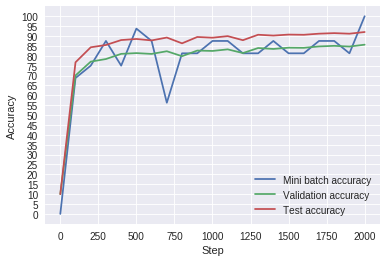

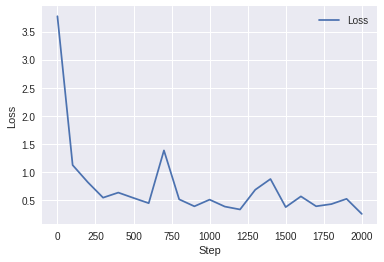

In [46]:
num_steps = 2001

mini_batch_loss_list = []
mini_batch_acc = []
valid_acc = []
test_acc = []
step_list = []
loss_list = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            loss_list.append(l)
            mini_batch_acc.append(accuracy(predictions, batch_labels))
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            test_acc.append(accuracy(test_prediction.eval(), test_labels))
            step_list.append(step)
        if (step % 200 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            #print('Minibatch accuracy: %.1f%%' % accuracy(
            #    predictions, batch_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(
            #    valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(
           test_prediction.eval(), test_labels))
plot_acc([mini_batch_acc, valid_acc, test_acc], step_list, 
         ['Mini batch accuracy', 'Validation accuracy', 'Test accuracy'])
plot_acc([loss_list], step_list, ['Loss'], y_label="Loss")

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [0]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
          tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(
          tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal
         ([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer2_weights = tf.Variable(tf.truncated_normal
         ([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

    layer3_weights = tf.Variable(tf.truncated_normal
         ([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # MaxPool2D wrapper
    def maxpool2d(data, k=2):
        return tf.nn.max_pool(data, ksize=[1,k,k,1], strides=[1,k,k,1],
                             padding='SAME')
    # Model.
    def model(data):
        conv1 = tf.nn.conv2d(
                data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden1 = tf.nn.relu(conv1 + layer1_biases)
        max_pool1 = maxpool2d(hidden1, k=2)
        
        conv2 = tf.nn.conv2d(
                max_pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden2 = tf.nn.relu(conv2 + layer2_biases)
        max_pool2 = maxpool2d(hidden2, k=2)
        
        shape = max_pool2.get_shape().as_list()
        reshape = tf.reshape(
                    max_pool2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(
                tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        return tf.matmul(hidden, layer4_weights) + layer4_biases
    
  
    
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 3.494331
Minibatch loss at step 200: 0.696901
Minibatch loss at step 400: 0.495640
Minibatch loss at step 600: 0.425410
Minibatch loss at step 800: 0.760195
Minibatch loss at step 1000: 0.306992
Minibatch loss at step 1200: 0.205122
Minibatch loss at step 1400: 0.689365
Minibatch loss at step 1600: 0.582382
Minibatch loss at step 1800: 0.322708
Minibatch loss at step 2000: 0.250403
Test accuracy: 92.6%


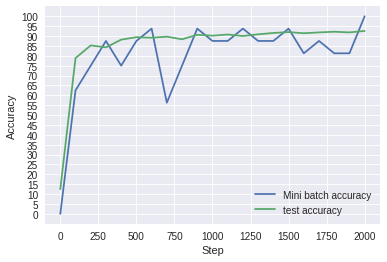

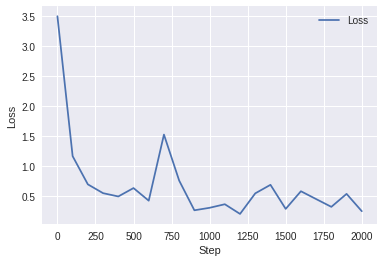

In [48]:
num_steps = 2001

mini_batch_loss_list = []
mini_batch_acc = []
valid_acc = []
test_acc = []
step_list = []
loss_list = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            loss_list.append(l)
            mini_batch_acc.append(accuracy(predictions, batch_labels))
            #valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            test_acc.append(accuracy(test_prediction.eval(), test_labels))
            step_list.append(step)
        if (step % 200 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            #print('Minibatch accuracy: %.1f%%' % accuracy(
            #    predictions, batch_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(
            #    valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(
           test_prediction.eval(), test_labels))
plot_acc([mini_batch_acc, test_acc], step_list, 
         ['Mini batch accuracy', 'test accuracy'])
plot_acc([loss_list], step_list, ['Loss'], y_label="Loss")

<tf.Tensor 'Softmax_1:0' shape=(105820, 10) dtype=float32>

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

LeNet5-inspired architecture

In [0]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

dropout_prob =0.45

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
          tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(
          tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal
         ([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer2_weights = tf.Variable(tf.truncated_normal
         ([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

    size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
    layer3_weights = tf.Variable(tf.truncated_normal(
      [size3 * size3 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Add dropout
    #dropout_prob = tf.placeholder("float")
    
    # Pool wrapper
    # 0 = max_pool and 1 = avg_pool
    def pooling(data, pool_type=0, k=2, padding_type='SAME'):
        if pool_type == 0:
            return tf.nn.max_pool(data, ksize=[1,k,k,1], strides=[1,k,k,1],
                             padding=padding_type)
        elif pool_type == 1:
            return tf.nn.avg_pool(data, ksize=[1,k,k,1], strides=[1,k,k,1],
                             padding=padding_type)
    # Model.
    def model(data, dropout_prob):
        # C1 input 28x28 (Conv 1)
        conv1 = tf.nn.conv2d(
                data, layer1_weights, [1, 1, 1, 1], padding='VALID')
        hidden1 = tf.nn.relu(conv1 + layer1_biases)
        
        # S2 input 24x24 (Subsampling 1)
        pool1 = pooling(hidden1, 1, 2, 'VALID')
        
        # C3 input 12x12 (Conv 3)
        conv3 = tf.nn.conv2d(
                pool1, layer2_weights, [1, 1, 1, 1], padding='VALID')
        hidden3 = tf.nn.relu(conv3 + layer2_biases)

        # S4 input 8x8 (Subsampling 4)
        pool4 = pooling(hidden3, 1, 2, 'VALID')
        
       
        shape = pool4.get_shape().as_list()
        pool4_reshape = tf.reshape(
                    pool4, [shape[0], shape[1] * shape[2] * shape[3]])
        # C5
        hidden5 = tf.nn.relu(
                tf.matmul(pool4_reshape, layer3_weights) + layer3_biases)
                
        # F6
        hidden6 = tf.matmul(hidden5, layer4_weights) + layer4_biases
        
        return hidden6
    
  
    
    # Training computation.
    logits = model(tf_train_dataset, dropout_prob)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))

Initialized
Minibatch loss at step 0: 2.922197
Minibatch loss at step 200: 1.100657
Minibatch loss at step 400: 0.674862
Minibatch loss at step 600: 0.611725
Minibatch loss at step 800: 1.037885
Minibatch loss at step 1000: 0.575935
Minibatch loss at step 1200: 0.329962
Minibatch loss at step 1400: 1.097862
Minibatch loss at step 1600: 0.577014
Minibatch loss at step 1800: 0.447547
Minibatch loss at step 2000: 0.332841
Test accuracy: 91.2%


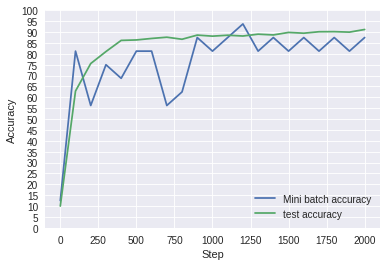

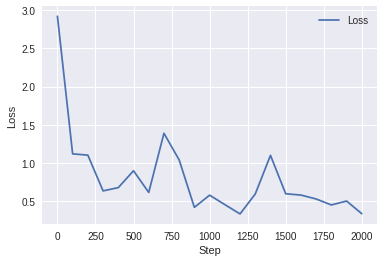

In [12]:
num_steps = 2001

mini_batch_loss_list = []
mini_batch_acc = []
valid_acc = []
test_acc = []
step_list = []
loss_list = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels
                    }
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 100 == 0):
            loss_list.append(l)
            mini_batch_acc.append(accuracy(predictions, batch_labels))
            #valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            test_acc.append(accuracy(test_prediction.eval(), test_labels))
            step_list.append(step)
        if (step % 200 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            #print('Minibatch accuracy: %.1f%%' % accuracy(
            #    predictions, batch_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(
            #    valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(
           test_prediction.eval(), test_labels))
plot_acc([mini_batch_acc, test_acc], step_list, 
         ['Mini batch accuracy', 'test accuracy'])
plot_acc([loss_list], step_list, ['Loss'], y_label="Loss")

**LeNet5 with dropout, regularization and learning rate decay**

In [0]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

dropout_prob =0.5
beta = 0.001

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
          tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(
          tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal
         ([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer2_weights = tf.Variable(tf.truncated_normal
         ([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))

    size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
    layer3_weights = tf.Variable(tf.truncated_normal(
      [size3 * size3 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Pool wrapper
    # 0 = max_pool and 1 = avg_pool
    def pooling(data, pool_type=0, k=2, padding_type='SAME'):
        if pool_type == 0:
            return tf.nn.max_pool(data, ksize=[1,k,k,1], strides=[1,k,k,1],
                             padding=padding_type)
        elif pool_type == 1:
            return tf.nn.avg_pool(data, ksize=[1,k,k,1], strides=[1,k,k,1],
                             padding=padding_type)
    # Model.
    def model(data, dropout_prob):
        # C1 input 28x28 (Conv 1)
        conv1 = tf.nn.conv2d(
                data, layer1_weights, [1, 1, 1, 1], padding='VALID')
        hidden1 = tf.nn.relu(conv1 + layer1_biases)
        
        # S2 input 24x24 (Subsampling 1)
        pool1 = pooling(hidden1, 1, 2, 'VALID')
        
        # C3 input 12x12 (Conv 3)
        conv3 = tf.nn.conv2d(
                pool1, layer2_weights, [1, 1, 1, 1], padding='VALID')
        hidden3 = tf.nn.relu(conv3 + layer2_biases)
        
        # S4 input 8x8 (Subsampling 4)
        pool4 = pooling(hidden3, 1, 2, 'VALID')
        
       
        shape = pool4.get_shape().as_list()
        pool4_reshape = tf.reshape(
                    pool4, [shape[0], shape[1] * shape[2] * shape[3]])
        # C5
        hidden5 = tf.nn.relu(
                tf.matmul(pool4_reshape, layer3_weights) + layer3_biases)
        
        hidden5_dropout = tf.nn.dropout(hidden5, dropout_prob)
        
        # F6
        hidden6 = tf.matmul(hidden5_dropout, layer4_weights) + layer4_biases
        hidden6_dropout = tf.nn.dropout(hidden6, dropout_prob)
        
        return hidden6_dropout
    
  
    
    # Training computation.
    logits = model(tf_train_dataset, dropout_prob)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,
                                                logits=logits))
    # L2 regularization
    reg = tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) + \
            tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights)
    loss = tf.reduce_mean(loss + beta * reg)

    # Optimizer using gradient descent
    global_step = tf.Variable(0)  
    l_rate = tf.placeholder("float")
    learning_rate = tf.train.exponential_decay(
            l_rate, global_step, 10000, 0.95, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
                loss, global_step= global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))

Initialized
Minibatch loss at step 0: 5.734008
Minibatch loss at step 200: 2.191890
Minibatch loss at step 400: 1.865414
Minibatch loss at step 600: 1.796216
Minibatch loss at step 800: 1.866076
Minibatch loss at step 1000: 1.274608
Minibatch loss at step 1200: 1.833459
Minibatch loss at step 1400: 1.302211
Minibatch loss at step 1600: 1.807464
Minibatch loss at step 1800: 1.585041
Minibatch loss at step 2000: 1.706911
Test accuracy: 89.2%


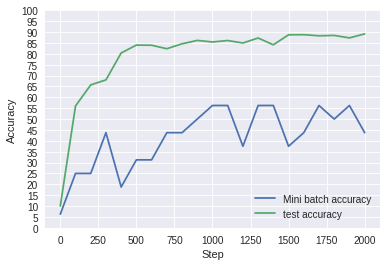

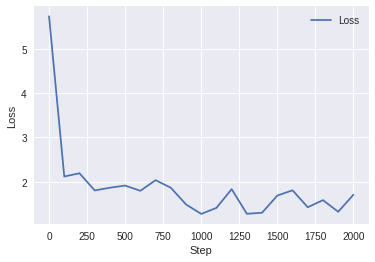

In [53]:
num_steps = 2001
step_info = num_steps // 10

learning_rate = 0.1

mini_batch_loss_list = []
mini_batch_acc = []
valid_acc = []
test_acc = []
step_list = []
loss_list = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels,
                     l_rate : learning_rate
                    }
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 100 == 0):
            loss_list.append(l)
            mini_batch_acc.append(accuracy(predictions, batch_labels))
            #valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            test_acc.append(accuracy(test_prediction.eval(), test_labels))
            step_list.append(step)
        if (step % step_info == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            #print('Minibatch accuracy: %.1f%%' % accuracy(
            #    predictions, batch_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(
            #    valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(
           test_prediction.eval(), test_labels))
plot_acc([mini_batch_acc, test_acc], step_list, 
         ['Mini batch accuracy', 'test accuracy'])
plot_acc([loss_list], step_list, ['Loss'], y_label="Loss")